In [ ]:
pip install yellowbrick

In [81]:
pip install treeinterpreter

Note: you may need to restart the kernel to use updated packages.


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yellowbrick

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)  # Unlimited columns.
pd.options.mode.use_inf_as_na = True        # Any inf or -inf is 
                                            # treated as NA.

In [5]:
##Plot function for Confusion Matrix

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
from sklearn.metrics import confusion_matrix
labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [6]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [7]:
X_train_original = pd.read_csv('./trainingSetValues.csv', 
                               header = [0],  # Top row is header.
                               index_col = 0) # First col is index.
X_train_original.head()


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
y_train_original = pd.read_csv('./trainingSetLabels.csv', header = [0], index_col = 0)
y_train_original.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [9]:
pd.value_counts(y_train_original.status_group, normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

1st Prediction

In [11]:
X_test_original = pd.read_csv('./testSetValues.csv', header = [0], index_col = 0)
X_test_original.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2/4/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2/4/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2/1/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,1/22/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,3/27/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [12]:
X_test_original.shape

(14850, 39)

In [13]:
y_pred = ['functional'] * len(X_test_original)
y_pred = pd.DataFrame(data = y_pred, 
                      index = X_test_original.index.values,
                      columns = ['status_group'])
y_pred.head()

,status_group
50785,functional
51630,functional
17168,functional
45559,functional
49871,functional


In [14]:
y_pred.to_csv('./1st_pred.csv', 
          header = ['status_group'],
          index = True,
             index_label = 'id')

In [15]:
y_pred.shape

(14850, 1)

In [16]:
pd.value_counts(y_train_original.status_group, normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

#Traning with numerical values

In [17]:
X_train_numerical = X_train_original.select_dtypes(
                         include = np.number).copy()

Checking Numerical values

In [18]:
days_since_epoch = pd.to_datetime(X_train_original['date_recorded']) - pd.datetime(1970, 1, 1)
X_train_numerical['days_since_epoch'] = days_since_epoch.dt.days
X_train_numerical.head()

<ipython-input-18-f0c0127ee540>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days_since_epoch = pd.to_datetime(X_train_original['date_recorded']) - pd.datetime(1970, 1, 1)


,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,days_since_epoch
id,,,,,,,,,,
69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999,15047
8776,0.0,1399,34.698766,-2.147466,0,20,2,280,2010,15770
34310,25.0,686,37.460664,-3.821329,0,21,4,250,2009,15761
67743,0.0,263,38.486161,-11.155298,0,90,63,58,1986,15733
19728,0.0,0,31.130847,-1.825359,0,18,1,0,0,15168


In [19]:
X_train_numerical_indices = X_train_numerical.index.values
y_train_numerical = y_train_original[y_train_original.index. \
                                    isin(X_train_numerical_indices)]

# Logistic Regression

In [20]:
cv_score = cross_val_score(LogisticRegression(), 
                            X_train_numerical, y_train_numerical,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.2s finished


array([0.55717172, 0.55631313, 0.55191919])

# Decision Tree

In [82]:
clf = DecisionTreeClassifier()
cv_score = cross_val_score(clf, 
                            X_train_numerical, y_train_numerical,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


array([0.67136364, 0.67015152, 0.65762626])

<ipython-input-76-2012e9cc4787>:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


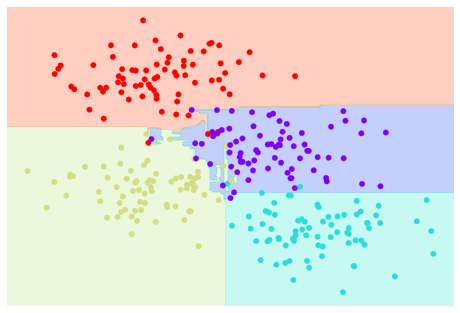

In [84]:
bag.fit(X, y)
visualize_classifier(bag, X, y)

In [23]:
clf.fit(X_train_numerical, y_train_numerical)
X_test_numerical = X_test_original.select_dtypes(include = np.number).copy()
days_since_epoch = pd.to_datetime(X_test_original['date_recorded']) - pd.datetime(1970, 1, 1)
X_test_numerical['days_since_epoch'] = days_since_epoch.dt.days
y_pred = clf.predict(X_test_numerical)
y_pred = pd.DataFrame(data = y_pred, 
                      index = X_test_numerical.index.values,
                      columns = ['status_group'])
y_pred.to_csv('./decision_tree_pred.csv', 
              header = ['status_group'],
              index = True,
              index_label = 'id')

<ipython-input-23-efa46367838d>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days_since_epoch = pd.to_datetime(X_test_original['date_recorded']) - pd.datetime(1970, 1, 1)


In [24]:
X_train_original.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [25]:
X_non_nulls = X_train_original.dropna(axis = 1) ## How many null values

In [26]:
X_non_nulls.nunique().sort_values(ascending = True) ## number of unique values

recorded_by                  1
source_class                 3
management_group             5
quantity_group               5
quantity                     5
quality_group                6
waterpoint_type_group        6
payment_type                 7
payment                      7
source_type                  7
waterpoint_type              7
extraction_type_class        7
water_quality                8
basin                        9
source                      10
management                  12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 65
amount_tsh                  98
lga                        125
date_recorded              356
population                1049
ward                      2092
gps_height                2428
wpt_name                 37400
longitude                57516
latitude                 57517
dtype: i

In [76]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

# Decision Tree Classifier

In [77]:
X_selected = X_non_nulls.loc[:, X_non_nulls.nunique().sort_values()\
                             < 50]
cat_cols = list(X_selected.select_dtypes(['object']).columns.values)
X_categorical = X_selected[cat_cols]. \
                  apply(lambda x: x.astype('category').cat.codes)
X_train_selected = X_train_numerical.join(X_categorical)
clf = DecisionTreeClassifier().fit(X, y)
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)
cv_score = cross_val_score(clf, 
                            X_train_selected, y_train_original,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


array([0.75353535, 0.74944444, 0.74656566])

<ipython-input-76-2012e9cc4787>:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


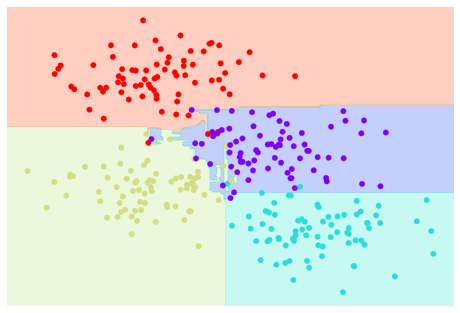

In [78]:
bag.fit(X, y)
visualize_classifier(bag, X, y)

<AxesSubplot:>

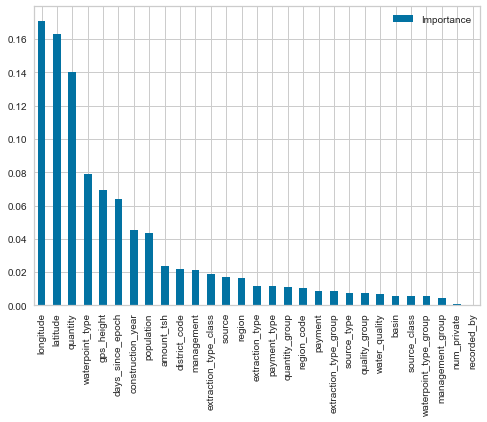

In [28]:
model = clf.fit(X_train_selected,y_train_original)
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train_selected.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

# Random Forrest Classifier

In [85]:
clf.fit(X_train_selected, y_train_original)
X_test_non_nulls = X_test_original.dropna(axis = 1)
X_test_selected = X_test_non_nulls.loc[:, X_test_non_nulls.nunique().sort_values() < 50]
cat_cols = list(X_test_selected.select_dtypes(['object']).columns.values)
X_test_categorical = X_test_selected[cat_cols].apply(lambda x:x.astype('category').cat.codes)
X_test_selected = X_test_numerical.join(X_test_categorical)
y_pred = clf.predict(X_test_selected)
y_pred = pd.DataFrame(data = y_pred, 
                      index = X_test_selected.index.values,
                      columns = ['status_group'])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_selected, y_train_original, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<ipython-input-86-795ce8151c9b>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8075757575757576

<ipython-input-31-3f417fe5e444>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = clf.fit(X_train,y_train)


<AxesSubplot:>

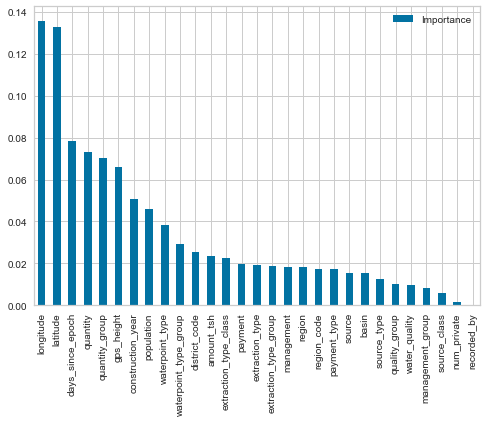

In [31]:
model = clf.fit(X_train,y_train)
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train_selected.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

<ipython-input-76-2012e9cc4787>:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


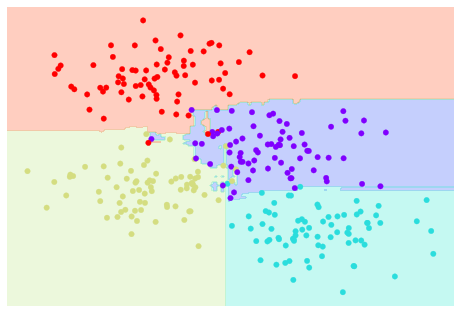

In [87]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

In [32]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [6, 10, 20, 30]
}
gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = -1), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=10)
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START max_depth=6, n_estimators=10...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 1/12] END .............max_depth=6, n_estimators=10; total time=   0.2s
[CV 2/3; 1/12] START max_depth=6, n_estimators=10...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 1/12] END .............max_depth=6, n_estimators=10; total time=   0.2s
[CV 3/3; 1/12] START max_depth=6, n_estimators=10...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 1/12] END .............max_depth=6, n_estimators=10; total time=   0.2s
[CV 1/3; 2/12] START max_depth=6, n_estimators=20...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 2/12] END .............max_depth=6, n_estimators=20; total time=   0.2s
[CV 2/3; 2/12] START max_depth=6, n_estimators=20...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 2/12] END .............max_depth=6, n_estimators=20; total time=   0.2s
[CV 3/3; 2/12] START max_depth=6, n_estimators=20...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 2/12] END .............max_depth=6, n_estimators=20; total time=   0.2s
[CV 1/3; 3/12] START max_depth=6, n_estimators=30...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 3/12] END .............max_depth=6, n_estimators=30; total time=   0.5s
[CV 2/3; 3/12] START max_depth=6, n_estimators=30...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 3/12] END .............max_depth=6, n_estimators=30; total time=   0.5s
[CV 3/3; 3/12] START max_depth=6, n_estimators=30...............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 3/12] END .............max_depth=6, n_estimators=30; total time=   0.5s
[CV 1/3; 4/12] START max_depth=10, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 4/12] END ............max_depth=10, n_estimators=10; total time=   0.3s
[CV 2/3; 4/12] START max_depth=10, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 4/12] END ............max_depth=10, n_estimators=10; total time=   0.2s
[CV 3/3; 4/12] START max_depth=10, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 4/12] END ............max_depth=10, n_estimators=10; total time=   0.2s
[CV 1/3; 5/12] START max_depth=10, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 5/12] END ............max_depth=10, n_estimators=20; total time=   0.3s
[CV 2/3; 5/12] START max_depth=10, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 5/12] END ............max_depth=10, n_estimators=20; total time=   0.3s
[CV 3/3; 5/12] START max_depth=10, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 5/12] END ............max_depth=10, n_estimators=20; total time=   0.5s
[CV 1/3; 6/12] START max_depth=10, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 6/12] END ............max_depth=10, n_estimators=30; total time=   0.6s
[CV 2/3; 6/12] START max_depth=10, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 6/12] END ............max_depth=10, n_estimators=30; total time=   0.4s
[CV 3/3; 6/12] START max_depth=10, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 6/12] END ............max_depth=10, n_estimators=30; total time=   0.4s
[CV 1/3; 7/12] START max_depth=20, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 7/12] END ............max_depth=20, n_estimators=10; total time=   0.3s
[CV 2/3; 7/12] START max_depth=20, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 7/12] END ............max_depth=20, n_estimators=10; total time=   0.4s
[CV 3/3; 7/12] START max_depth=20, n_estimators=10..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 7/12] END ............max_depth=20, n_estimators=10; total time=   0.3s
[CV 1/3; 8/12] START max_depth=20, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 8/12] END ............max_depth=20, n_estimators=20; total time=   0.6s
[CV 2/3; 8/12] START max_depth=20, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 8/12] END ............max_depth=20, n_estimators=20; total time=   0.5s
[CV 3/3; 8/12] START max_depth=20, n_estimators=20..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 8/12] END ............max_depth=20, n_estimators=20; total time=   0.5s
[CV 1/3; 9/12] START max_depth=20, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 9/12] END ............max_depth=20, n_estimators=30; total time=   0.6s
[CV 2/3; 9/12] START max_depth=20, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 9/12] END ............max_depth=20, n_estimators=30; total time=   0.7s
[CV 3/3; 9/12] START max_depth=20, n_estimators=30..............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 9/12] END ............max_depth=20, n_estimators=30; total time=   0.6s
[CV 1/3; 10/12] START max_depth=30, n_estimators=10.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 10/12] END ...........max_depth=30, n_estimators=10; total time=   0.5s
[CV 2/3; 10/12] START max_depth=30, n_estimators=10.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 10/12] END ...........max_depth=30, n_estimators=10; total time=   0.6s
[CV 3/3; 10/12] START max_depth=30, n_estimators=10.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 10/12] END ...........max_depth=30, n_estimators=10; total time=   0.4s
[CV 1/3; 11/12] START max_depth=30, n_estimators=20.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 11/12] END ...........max_depth=30, n_estimators=20; total time=   0.5s
[CV 2/3; 11/12] START max_depth=30, n_estimators=20.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 11/12] END ...........max_depth=30, n_estimators=20; total time=   0.5s
[CV 3/3; 11/12] START max_depth=30, n_estimators=20.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 11/12] END ...........max_depth=30, n_estimators=20; total time=   0.6s
[CV 1/3; 12/12] START max_depth=30, n_estimators=30.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3; 12/12] END ...........max_depth=30, n_estimators=30; total time=   0.8s
[CV 2/3; 12/12] START max_depth=30, n_estimators=30.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3; 12/12] END ...........max_depth=30, n_estimators=30; total time=   0.9s
[CV 3/3; 12/12] START max_depth=30, n_estimators=30.............................


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3; 12/12] END ...........max_depth=30, n_estimators=30; total time=   0.7s


C:\Users\845515\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [6, 10, 20, 30],
                         'n_estimators': [10, 20, 30]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [35]:
pd.DataFrame(gridsearch.cv_results_).sort_values( \
                                         by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
8,0.632605,0.052350,0.100425,0.024671,20,30,"{'max_depth': 20, 'n_estimators': 30}",0.800189,0.798485,0.800821,0.799832,0.000987,1,0.953188,0.954198,0.954861,0.954082,0.000688
7,0.579318,0.036469,0.069262,0.003847,20,20,"{'max_depth': 20, 'n_estimators': 20}",0.798737,0.796907,0.796338,0.797327,0.001024,2,0.944350,0.953220,0.950189,0.949253,0.003681
11,0.804448,0.114453,0.087759,0.027393,30,30,"{'max_depth': 30, 'n_estimators': 30}",0.794760,0.793308,0.794444,0.794171,0.000624,3,0.994129,0.994697,0.995044,0.994623,0.000377
6,0.366457,0.044401,0.061269,0.034839,20,10,"{'max_depth': 20, 'n_estimators': 10}",0.791162,0.791351,0.792235,0.791582,0.000468,4,0.935638,0.942361,0.939899,0.939299,0.002777
10,0.547835,0.071668,0.101027,0.003832,30,20,"{'max_depth': 30, 'n_estimators': 20}",0.790909,0.789899,0.791730,0.790846,0.000749,5,0.990972,0.991383,0.991635,0.991330,0.000273
9,0.515076,0.070210,0.059261,0.030381,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.787058,0.786553,0.789899,0.787837,0.001473,6,0.979135,0.979766,0.980429,0.979777,0.000528
4,0.416215,0.091054,0.047265,0.034916,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.757323,0.753914,0.759912,0.757050,0.002456,7,0.779388,0.770455,0.771559,0.773801,0.003976
5,0.488254,0.064593,0.054475,0.028416,10,30,"{'max_depth': 10, 'n_estimators': 30}",0.753662,0.751073,0.759343,0.754693,0.003454,8,0.774306,0.768624,0.772064,0.771665,0.002337
3,0.295464,0.041006,0.036210,0.007289,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.750758,0.756566,0.754230,0.753851,0.002386,9,0.770423,0.770139,0.765057,0.768540,0.002465
2,0.513669,0.013840,0.062856,0.018600,6,30,"{'max_depth': 6, 'n_estimators': 30}",0.720265,0.721338,0.728283,0.723295,0.003554,10,0.724621,0.725000,0.726136,0.725253,0.000644


In [36]:
clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<ipython-input-36-854b74c08257>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8055555555555556

<ipython-input-37-ce63a815e67c>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = clf.fit(X_train_selected,y_train_original)


<AxesSubplot:>

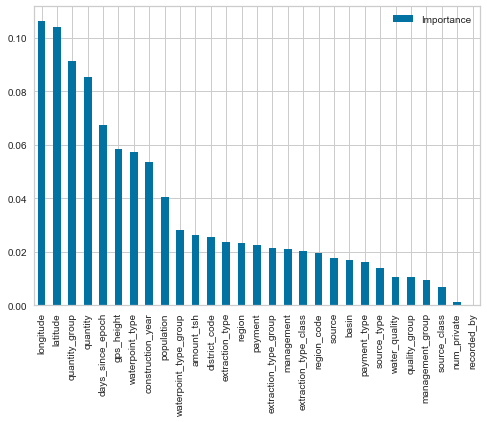

In [37]:
model = clf.fit(X_train_selected,y_train_original)
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train_selected.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

In [43]:
clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<ipython-input-43-854b74c08257>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8031144781144781

In [44]:
clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = -1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

<ipython-input-44-854b74c08257>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.8080808080808081

In [93]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# create 50 separable points
X, y = make_blobs(n_samples=100, centers=4,
                  random_state=42, cluster_std=1.5)

# Fit the K Means model
model = KMeans(4, random_state=0)
y = model.fit_predict(X)

ModuleNotFoundError: No module named 'sklearn.datasets.samples_generator'